In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['spark-3.0.2']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [22.9 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://s

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   45610553| RMDCHWD0Y5OZ9|B00HH62VB6|     618218723|AGPtek® 10 Isolat...|Musical Instruments|          3|            0|          1|   N|                N|         Three Stars|Works very good, ...| 2015-08-31|
|         US|   14640079| RZSL0BALIYUNU|B003LRN53I|     986692292|Sennheiser HD203 ...|Musical Instruments| 

In [ ]:
#to check the datatypes in the dataframe
df.schema

StructType(List(StructField(marketplace,StringType,true),StructField(customer_id,IntegerType,true),StructField(review_id,StringType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(product_title,StringType,true),StructField(product_category,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true),StructField(review_headline,StringType,true),StructField(review_body,StringType,true),StructField(review_date,StringType,true)))

### Create DataFrames to match tables

In [ ]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame
customer_clean_df = df.dropna()
customer_clean_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   45610553| RMDCHWD0Y5OZ9|B00HH62VB6|     618218723|AGPtek® 10 Isolat...|Musical Instruments|          3|            0|          1|   N|                N|         Three Stars|Works very good, ...| 2015-08-31|
|         US|   14640079| RZSL0BALIYUNU|B003LRN53I|     986692292|Sennheiser HD203 ...|Musical Instruments| 

In [ ]:
# Drop duplicates
customer_clean_1_df = customer_clean_df.drop_duplicates()
customer_clean_1_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|   product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+-------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   12078619|R100LMJJNWFDJK|B00B054NVG|     963648561|Odyssey FZGSPIDDJ...|Musical Instruments|          5|            0|          0|   N|                Y|          Five Stars|      beautiful case| 2014-10-24|
|         US|   43421823|R10106OQ9QP86T|B004W4TYMA|     461512942|BEHRINGER EUROPOW...|Musical Instruments| 

In [ ]:
# Create the customers_table DataFrame
customers_df = customer_clean_df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   27314089|             1|
|    6711334|             1|
|   44525866|             4|
|   47461997|             1|
|   42560427|             1|
+-----------+--------------+
only showing top 5 rows



In [ ]:
customers_df.schema

StructType(List(StructField(customer_id,IntegerType,true),StructField(customer_count,LongType,false)))

In [ ]:
# Create the products_table DataFrame and drop duplicates.
#df.filter("price<20").select("points","country","price").show(5)
products_df = customer_clean_df.select(["product_id","product_title"]).drop_duplicates()
products_df.show(20)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B003WZXSWM|Grover 205BC Mini...|
|B00ASHQQKI|SUPERNIGHT 5050 1...|
|B000T4BC1I|Aulos A211A/A511B...|
|B005I0HTCY|Neewer Black 3.5m...|
|B00JJ18VIE|Reliable Hardware...|
|B00US77MXI|Pick Geek Guitar ...|
|B00S5O7HZO|Glory B Flat Clar...|
|B007CPU1A0|Meinl Headliner T...|
|B0002E3D9Y|PACK A STAND Clar...|
|B00J3W1F96|Zildjian 5A Acorn...|
|B0006NMUJU|Shure Foam Windsc...|
|B0018SJLFS|Tung-Sol 12AX7 Pr...|
|B00N0HXT94|Akai Professional...|
|B0006GRRQI|Gator G-PG ACOUST...|
|B005DJOI8I|Neewer 3.5mm Hand...|
|B000WS1QC6|Yamaha PA130 120 ...|
|B00IEQ4CVK|4/4 Size Electric...|
|B0080GZPRY|VocoPro CARRY-OKE...|
|B00I4ZMW2C|San Fransisco Gia...|
|B000F9NBZC|Tapco by Mackie M...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
products_df.schema

StructType(List(StructField(product_id,StringType,true),StructField(product_title,StringType,true)))

In [ ]:
# Create the review_id_table DataFrame.
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show(10)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
| RMDCHWD0Y5OZ9|   45610553|B00HH62VB6|     618218723| 2015-08-31|
| RZSL0BALIYUNU|   14640079|B003LRN53I|     986692292| 2015-08-31|
| RIZR67JKUDBI0|    6111003|B0006VMBHI|     603261968| 2015-08-31|
|R27HL570VNL85F|    1546619|B002B55TRG|     575084461| 2015-08-31|
|R34EBU9QDWJ1GD|   12222213|B00N1YPXW2|     165236328| 2015-08-31|
|R1WCUI4Z1SIQEO|   46018513|B001N4GRGS|     134151483| 2015-08-31|
| RL5LNO26GAVJ1|   10225065|B009PJRMHQ|     694166585| 2015-08-31|
|R3GYQ5W8JHP8SB|    6356995|B00NKBDAZS|     446431775| 2015-08-31|
|R30SHYQXGG5EYC|   35297198|B006MIU7U2|     125871705| 2015-08-31|
|R14YLXA56NP51I|   32139520|B000FIBD0I|     771888534| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 10 rows



In [ ]:
review_id_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(customer_id,IntegerType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(review_date,DateType,true)))

In [ ]:
# Create the vine_table. DataFrame
vine_df = customer_clean_1_df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R100LMJJNWFDJK|          5|            0|          0|   N|                Y|
|R10106OQ9QP86T|          5|            0|          1|   N|                Y|
|R101ER44F5J3EK|          5|            0|          0|   N|                Y|
|R1036AJM4DUM64|          4|            0|          0|   N|                Y|
|R103CWY3MPPRYB|          2|            0|          0|   N|                Y|
|R104VHJ7WLB4PP|          5|            0|          0|   N|                Y|
|R105A5ZRV1UHT1|          5|            0|          0|   N|                N|
|R105RU48J2VL19|          5|           12|         12|   N|                Y|
|R106LKOCWLJKP1|          1|            2|          8|   N|                N|
|R106NRR8JSGUID|          5|            0|          0|   N|     

In [ ]:
vine_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#we need to convert the "star_rating" datatype into integer , since we have defined it as an integer in the "vine_table" we created in pgAdmin.
#review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
#data_df = data_df.withColumn("Plays", data_df["Plays"].cast(IntegerType()))
#customers_df = customers_df.withColumn("customer_count",col("customer_count").cast("int"))
vine1_df = vine_df.select(["review_id",vine_df["star_rating"].cast("int").alias("star_rating"),"helpful_votes","total_votes","vine","verified_purchase"])
vine1_df .show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R100LMJJNWFDJK|          5|            0|          0|   N|                Y|
|R10106OQ9QP86T|          5|            0|          1|   N|                Y|
|R101ER44F5J3EK|          5|            0|          0|   N|                Y|
|R1036AJM4DUM64|          4|            0|          0|   N|                Y|
|R103CWY3MPPRYB|          2|            0|          0|   N|                Y|
|R104VHJ7WLB4PP|          5|            0|          0|   N|                Y|
|R105A5ZRV1UHT1|          5|            0|          0|   N|                N|
|R105RU48J2VL19|          5|           12|         12|   N|                Y|
|R106LKOCWLJKP1|          1|            2|          8|   N|                N|
|R106NRR8JSGUID|          5|            0|          0|   N|     

In [ ]:
vine1_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

### Analysing the vine data

In [ ]:
# 1.Filter the Vine DataFrame by those that had 20+ total votes
df1 = vine1_df.filter(vine1_df["total_votes"] >= 20)
df1.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3PWR7ER9S8X8H|          1|           18|         24|   N|                Y|
|R3PQHUTHY5X837|          5|          115|        124|   N|                Y|
|R3LST9CCK16UB5|          4|           44|         47|   N|                Y|
| R5O75E41GBF3N|          4|           21|         24|   N|                Y|
|R2NSNAFWX4TU0Z|          3|           32|         32|   N|                Y|
|R39RN56RI7CUWP|          5|           43|         44|   N|                Y|
| R9Z7EPSMNXNTR|          5|           26|         27|   N|                Y|
|R2PBJUFM14IJBV|          5|           80|         83|   N|                Y|
|R2NHIWTHMBXSG6|          5|           26|         27|   N|                N|
|R24Q78NKVWJ06L|          5|           41|         43|   N|     

In [ ]:
#2.retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
df2 = df1.filter(df1["helpful_votes"]/df1["total_votes"] >= 0.5)
df2.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3PWR7ER9S8X8H|          1|           18|         24|   N|                Y|
|R3PQHUTHY5X837|          5|          115|        124|   N|                Y|
|R3LST9CCK16UB5|          4|           44|         47|   N|                Y|
| R5O75E41GBF3N|          4|           21|         24|   N|                Y|
|R2NSNAFWX4TU0Z|          3|           32|         32|   N|                Y|
|R39RN56RI7CUWP|          5|           43|         44|   N|                Y|
| R9Z7EPSMNXNTR|          5|           26|         27|   N|                Y|
|R2PBJUFM14IJBV|          5|           80|         83|   N|                Y|
|R2NHIWTHMBXSG6|          5|           26|         27|   N|                N|
|R24Q78NKVWJ06L|          5|           41|         43|   N|     

In [ ]:
#3.Create a new DataFrame or table that retrieves all the rows where a review was written as part of the Vine program (paid), vine == 'Y'.
vine_yes3_df = df2.filter(df2["vine"] == "Y")
vine_yes3_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R394FJYWZ0GNFG|          5|           40|         43|   Y|                N|
|R1WYQYB9KX1WM1|          5|           32|         36|   Y|                N|
|R3NGT6QJHCUOKV|          4|           34|         38|   Y|                N|
|R34DJ1R8AEU0SG|          5|           29|         35|   Y|                N|
|R25P5CXK5L9RHF|          5|          146|        161|   Y|                N|
| RP24DFOZY82Z9|          5|           24|         26|   Y|                N|
|R113X83B4OZYF8|          3|           37|         47|   Y|                N|
|R1ETBDZ1LJ8CEL|          4|           28|         32|   Y|                N|
| RYW05F1MUEF01|          5|           87|        102|   Y|                N|
|R33G6UUWX1SZ1W|          4|           36|         41|   Y|     

In [ ]:
#4.Create a new DataFrame and retrieve all the rows where the review was not part of the Vine program (unpaid), vine == 'N'.
vine_No4_df = df2.filter(df2["vine"] == "N")
vine_No4_df.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3PWR7ER9S8X8H|          1|           18|         24|   N|                Y|
|R3PQHUTHY5X837|          5|          115|        124|   N|                Y|
|R3LST9CCK16UB5|          4|           44|         47|   N|                Y|
| R5O75E41GBF3N|          4|           21|         24|   N|                Y|
|R2NSNAFWX4TU0Z|          3|           32|         32|   N|                Y|
|R39RN56RI7CUWP|          5|           43|         44|   N|                Y|
| R9Z7EPSMNXNTR|          5|           26|         27|   N|                Y|
|R2PBJUFM14IJBV|          5|           80|         83|   N|                Y|
|R2NHIWTHMBXSG6|          5|           26|         27|   N|                N|
|R24Q78NKVWJ06L|          5|           41|         43|   N|     

In [ ]:
vine_yes3_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5a.The number of 5-star reviews, and the percentage of 5-star reviews for the paid review vine == Y
Paid_five_star_number = vine_yes3_df[vine_yes3_df['star_rating']== 5].count()
Total_paid_number = vine_yes3_df.count()
Percentage_five_star_vine = float(Paid_five_star_number) / float(Total_paid_number)
print ("Total_paid_number:")
print(Total_paid_number)
print ("Paid_five_star_number:")
print(Paid_five_star_number)
print ("Percentage_five_star_vine:")
print(Percentage_five_star_vine)

Total_paid_number:
60
Paid_five_star_number:
34
Percentage_five_star_vine:
0.5666666666666667


In [ ]:
vine_No4_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5b.The number of 5-star reviews, and the percentage of 5-star reviews for the unpaid review vine == N
Unpaid_five_star_number = vine_No4_df[vine_No4_df['star_rating']== 5].count()
Total_Unpaid_number = vine_No4_df.count()
Percentage_five_star_vine_Unpaid = float(Unpaid_five_star_number) / float(Total_Unpaid_number)
print ("Total_Unpaid_number:")
print(Total_Unpaid_number)
print ("Unpaid_five_star_number:")
print(Unpaid_five_star_number)
print ("Percentage_five_star_vine_Unpaid:")
print(Percentage_five_star_vine_Unpaid)

Total_Unpaid_number:
14473
Unpaid_five_star_number:
8210
Percentage_five_star_vine_Unpaid:
0.5672631797139501


In [ ]:
import matplotlib.pyplot as plt,numpy as np

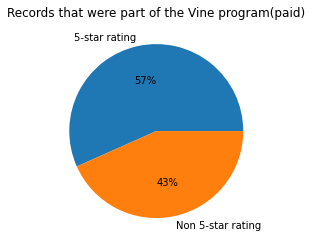

In [ ]:
p=np.array([Percentage_five_star_vine,1-Percentage_five_star_vine])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were part of the Vine program(paid)")
plt.show()

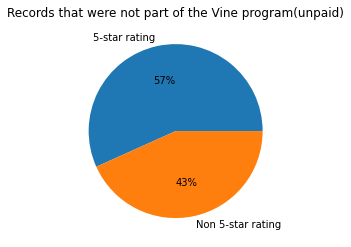

In [ ]:
p=np.array([Percentage_five_star_vine_Unpaid,1-Percentage_five_star_vine_Unpaid])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were not part of the Vine program(unpaid)")
plt.show()